\
<font color=blue size=7>**Analysis Draft**</font>\
Notebook focucing on 1 study case: Los Angeles (CA)

In [1]:
import os

import pickle as pkl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from matplotlib import cm, colors

import sys
sys.path.insert(0,"/home/user/my_packages/")

from my_packages.loadEPlus import prepare_building

In [2]:
root = '/home/user/Quicky_Horizon/Results/'

In [3]:
def get_building_load(city):### UPLOAD ORIGINAL DEMAND AND PV AVAILABILITY
    if city == 'LosAngeles':
        city = "Los.Angeles"
    
    files = os.listdir("../../Data/") # Gather building files
    file_epw = [f for f in files if ((f[-3:]=='epw')&(f.find(city)!=-1))][0]
    file_res = [f for f in files if ((f[7:10]=="Res")&(f.find(city)!=-1))][0]
    file_off = [f for f in files if ((f[7:10]=="Sma")&(f.lower().find(city.replace(".","_").lower())!=-1))][0]
    loads = {}

    loads['Residential'] = prepare_building(path_epw=f"../../Data/{file_epw}",
                            path_building=f"../../Data/{file_res}",
                            year=2011, withCold=False)
    loads['SmallOffice'] = prepare_building(path_epw=f"../../Data/{file_epw}",
                            path_building=f"../../Data/{file_off}",
                            year=2011, withCold=False)
    return loads

In [4]:
def invert_cmap(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return colors.LinearSegmentedColormap('colormap',cdict,1024)

\
<font color=green size=7>**Electric & Heat Systems** (Scenarios 5-8)</font>

# 1. Visualize Final sizing

In [9]:
def get_sizes(root, building, city, scenario):
    # Get file paths
    path = root+f"{building}/{city}/Scenario{scenario}/"
    files = sorted([k for k in os.listdir(path) if ((k[:6]=='sizing')&(k.find("_sizes")==-1)&(k.find("_perOpe")==-1))])
    
    # Load files
    results = {k:None for k in ['full','3M','M','W','d']} # Initialize results
    for f in files:
        categ = f.split("_")[1].replace(".pkl","").replace('ope','')
        with open(path+f, 'rb') as sol:
            results[categ] = pkl.Unpickler(sol).load()
    
    return results

In [10]:
def visualize_sizes(root, building, city, scenario):
    sizes = get_sizes(root, city=city, building=building,scenario=scenario)

    interest = ['Grid','PV','Boiler','HP','Battery','HWT']
    interest = ['PV']
    colors = {'full':'k', '3M':'b', 'M':'c','W':'red','d':'y'}
    linewidth = {'full':4, '3M':1.5, 'M':1.5,'W':1.5,'d':1.5}
    labels = ['Grid capacity [kW]','PV capacity [kWp]','Boiler capacity [kW$_{th}$]','HP capacity [kW$_{th}$]',
              'Battery capacity [kWh]','HWT capacity [kWh]']

    fig,axes = plt.subplots(1,len(interest),figsize=(25,3))
    for i,ax in enumerate(axes):
        lines = []
        for dt in sizes:
            lines += ax.plot(sizes[dt].loc['Carbon'], sizes[dt].loc[interest[i]], c=colors[dt], marker=".", label=dt, linewidth=linewidth[dt])
        ax.set_xlabel("$CO_2$ emissions [$kg_{CO_2, eq}/y$]", fontsize=13)
        ax.set_ylabel(labels[i], fontsize=13)
        ax.grid()
        ax.legend(lines, [l.get_label() for l in lines], fontsize=13)
        ax.set_title(f"{city} - {building} - S{scenario}",fontsize=13)
    plt.tight_layout()
    plt.show()

In [41]:
def visualize_sizes_paper(root, building, city, scenario, interest='PV'):
    sizes = get_sizes(root, city=city, building=building,scenario=scenario)
    
    colors = {'full':'k', '3M':'b', 'M':'c','W':'red','d':'y'}
    linewidth = {'full':4, '3M':1.5, 'M':1.5,'W':1.5,'d':1.5}
    labels = {'Grid':'Grid capacity [kW]','PV':'PV capacity [kWp]','Boiler':'Boiler capacity [kW$_{th}$]',
              'HP':'HP capacity [kW$_{th}$]','Battery':'Battery capacity [kWh]', 'HWT':'HWT capacity [kWh]'}
    legends =  {'full':'Y', '3M':'3M', 'M':'M','W':'W','d':'d'}

    fig,ax = plt.subplots(1,1,figsize=(4,3))
    
    lines = []
    for dt in sizes:
        lines += ax.plot(sizes[dt].loc['Carbon']/1000, sizes[dt].loc[interest], c=colors[dt], marker="o", label=legends[dt], linewidth=linewidth[dt])
    ax.set_xlabel("$CO_2$ after yearly operation [$t_{CO_2}/y$]", fontsize=13)
    ax.set_ylabel(labels[interest], fontsize=13)
    ax.grid()
    ax.legend(lines, [l.get_label() for l in lines], fontsize=13,title=' Sizing\nHorizon',title_fontsize=14)
    
    plt.savefig(f"../pictures/Horizon_Front_{building[:3]}_{city}_S{scenario}_{interest[:3]}.png", bbox_inches='tight')
    plt.show()

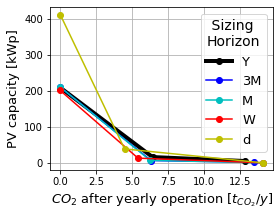

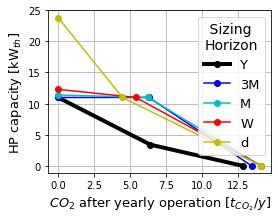

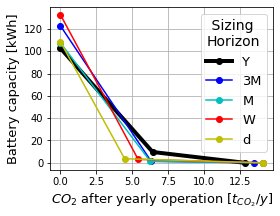

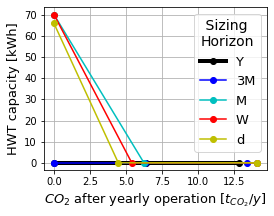

In [42]:
visualize_sizes_paper(root, building='Residential',city='Seattle',scenario=6, interest='PV')
visualize_sizes_paper(root, building='Residential',city='Seattle',scenario=6, interest='HP')
visualize_sizes_paper(root, building='Residential',city='Seattle',scenario=6, interest='Battery')
visualize_sizes_paper(root, building='Residential',city='Seattle',scenario=6, interest='HWT')

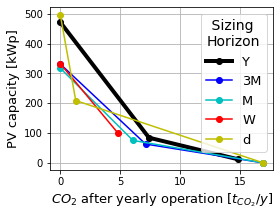

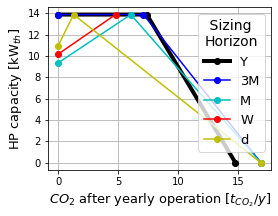

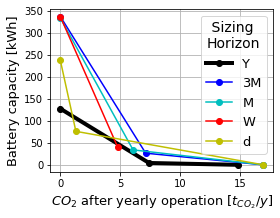

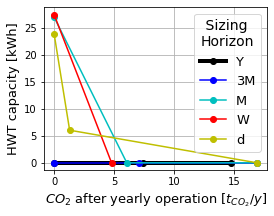

In [43]:
visualize_sizes_paper(root, building='SmallOffice',city='Houston',scenario=7, interest='PV')
visualize_sizes_paper(root, building='SmallOffice',city='Houston',scenario=7, interest='HP')
visualize_sizes_paper(root, building='SmallOffice',city='Houston',scenario=7, interest='Battery')
visualize_sizes_paper(root, building='SmallOffice',city='Houston',scenario=7, interest='HWT')

# 2. Visualize difference in Size after Sizing and Opertion
**Note**: We want to compare the initial sizing to the results obtained after operation. Capacities remain the same, however CO2 and Costs evolve. Therefore we may not be interested in dispatch devices. Cost and CO2 is of interest, as well as storages as they show most of the shift...

In [44]:
def get_sizes_evolution(root, building, city, scenario):
    # Get file paths
    path = root+f"{building}/{city}/Scenario{scenario}/"
    files = sorted([k for k in os.listdir(path) if ((k[:6]=='sizing')&(k.find("_sizes")==-1))])
    
    # Load files
    results = {} # Initialize results
    
    for f in files:
        categ = f.split("_")[1].replace(".pkl","").replace('ope','').replace("perOpe","")
        if categ in results: continue;
        else: results[categ] = {}
        
        if categ=='full':
            with open(path+f, 'rb') as sol:
                results[categ]['original'] = pkl.Unpickler(sol).load() # Original sizing
                results[categ]['opePart'] = results[categ]['original'] # Operation per period
                results[categ]['opeFull'] = results[categ]['original'] # Operation full
        else:
            with open(path+f, 'rb') as sol: # Operation for full
                results[categ]['opeFull'] = pkl.Unpickler(sol).load()
            with open(path+f.replace("_ope","_perOpe"),'rb') as sol: # Opetation per period
                results[categ]['periodOpe'] = pkl.Unpickler(sol).load()
            with open(path+f.replace('_ope','_sizes'), 'rb') as sol: # Operation from initial sizing
                results[categ]['period'] = pkl.Unpickler(sol).load()
                
            results[categ]['original'] = pd.concat((results[categ]['period'][pf].apply(lambda x: x.sum() if x.name in ['Operation','Carbon','time_total',
                                                                                                                       'time_solver'] else x.max(), axis=1)
                                                    for pf in results[categ]['period']), axis=1)
                
            results[categ]['opePart'] = pd.concat((results[categ]['periodOpe'][pf].apply(lambda x: x.sum() if x.name in ['Operation','Carbon','time_total',
                                                                                                                       'time_solver'] else x.max(), axis=1)
                                                    for pf in results[categ]['periodOpe']), axis=1)
            results[categ]['opePart'].loc['Cost']
    
    return results

In [45]:
def visualize_sizes_evolution(root, building, city, scenario):
    sizesEv = get_sizes_evolution(root, city=city, building=building,scenario=scenario)


    interest = ['Cost','Investment','Operation','Carbon']
    colors = {'full':'k', '3M':'b', 'M':'c','W':'red','d':'y'}
    labels = ['Annual Cost [$]','Investment cost [$]','Operation cost [$]','Posterior CO$_2$ [kgCO$_{2,eq}$/y]']
    markersizes = {'full':25,'3M':20,'M':15,'W':10,'d':5}
    linewidths = {'full':6, '3M':4, 'M':3, 'W':2, 'd':1}

    fig,axes = plt.subplots(3,4,figsize=(20,9))
    
    for j,row in enumerate(axes[:-1]): # 2 rows
        after = ['opePart','opeFull'][j] # Case for the graph: opeFull or opePart
        for i,ax in enumerate(row):
            lines = []
            lines_before = []

            if interest[i]=='Carbon':
                for dt in sizesEv:
                    lines += ax.plot(sizesEv[dt]['original'].loc['Carbon'], sizesEv[dt][after].loc[interest[i]], c=colors[dt],
                                     marker='.',markersize=markersizes[dt],label=dt, linewidth=linewidths[dt],alpha=.7)

                ax.set_xlabel("Prior $CO_2$ emissions [$kg_{CO_2, eq}/y$]", fontsize=13)
                ax.legend(lines, [l.get_label() for l in lines], fontsize=9, ncol=1)

            else:
                for dt in ['full','3M','M','W','d']:
                    lines_before += ax.plot(sizesEv[dt]['original'].loc['Carbon'], sizesEv[dt]['original'].loc[interest[i]], c=colors[dt],
                                            marker=".", markersize=markersizes[dt], linestyle='', label=" ", alpha=.8)
                    lines += ax.plot(sizesEv[dt][after].loc['Carbon'], sizesEv[dt][after].loc[interest[i]], c=colors[dt],
                                     linestyle='-', linewidth=linewidths[dt], label=dt, alpha=.7)

                lines += lines_before
                ax.set_xlabel("$CO_2$ emissions [$kg_{CO_2, eq}/y$]", fontsize=13)
                ax.legend(lines, [l.get_label() for l in lines], fontsize=9, ncol=2, title=f"{after[3:].capitalize()}     Original", title_fontsize=11)

            ax.set_ylabel(labels[i], fontsize=13)
            ax.grid()
            ax.set_title(f"{city} - {building} - S{scenario}",fontsize=13)
            
    for i,ax in enumerate(axes[-1]):
        lines = []
        lowest = min( 0, 1.2*sizesEv['full']['opeFull'].loc[interest[i]].min() )
        diagonal = ax.plot([lowest, 1.2*sizesEv['full']['opeFull'].loc[interest[i]].max()], [lowest, 1.2*sizesEv['full']['opeFull'].loc[interest[i]].max()], c='gray',
                            linestyle='--', label=" ")
        for dt in ['full','3M','M','W','d']:
            lines += ax.plot(sizesEv[dt]['opeFull'].loc[interest[i]], sizesEv[dt]['opePart'].loc[interest[i]], c=colors[dt],
                             linestyle='-', linewidth=linewidths[dt], marker='.', ms=markersizes[dt], label=dt, alpha=.7)
        
        ax.set_xlabel(labels[i], fontsize=13)
        ax.legend(lines, [l.get_label() for l in lines], fontsize=9)

        ax.set_ylabel(labels[i], fontsize=13)
        ax.grid()
        ax.set_title(f"{city} - {building} - S{scenario}",fontsize=13)
        
    plt.tight_layout()
    plt.show()

In [80]:
def visualize_carbon_paper(root, building, city, scenario, kind='Full'):
    sizesEv = get_sizes_evolution(root, city=city, building=building,scenario=scenario)
    
    colors = {'full':'k', '3M':'b', 'M':'c','W':'red','d':'y'}
    markersizes = {'full':25,'3M':20,'M':15,'W':10,'d':5}
    linewidths = {'full':6, '3M':4, 'M':3, 'W':2, 'd':1}
    legends =  {'full':'Y', '3M':'3M', 'M':'M','W':'W','d':'d'}
    factor = 1.5

    fig,ax = plt.subplots(1,1,figsize=(6,4.5))
    
    after = f"ope{kind}"


    lines = []


    for dt in sizesEv:
        lines += ax.plot(sizesEv[dt][after].loc['Carbon']/1000, sizesEv[dt]['original'].loc['Carbon']/1000, 
                         c=colors[dt], marker='.',markersize=factor*markersizes[dt],label=legends[dt], linewidth=factor*linewidths[dt],alpha=.7)

    ax.tick_params(axis='both', which='major', labelsize=15)
    
    ax.set_ylabel("$CO_2$ after sizing [$t_{CO_2}/y$]", fontsize=19)
    ax.legend(lines, [l.get_label() for l in lines], fontsize=16, ncol=1,title=' Sizing\nHorizon',title_fontsize=17)
    
    ax.set_xlabel('$CO_2$ after yearly operation [$t_{CO_2}/y$]', fontsize=19)
    ax.grid()
    
    plt.savefig(f"../pictures/Horizon_Front_{building[:3]}_{city}_S{scenario}_CO2.png", bbox_inches='tight')
    plt.show()

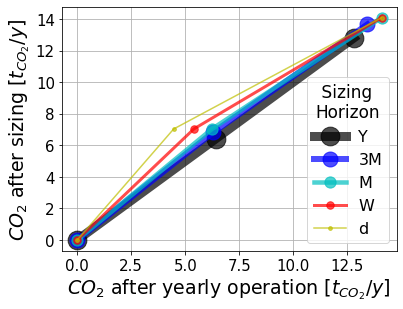

In [81]:
visualize_carbon_paper(root, building='Residential',city='Seattle', scenario=6)

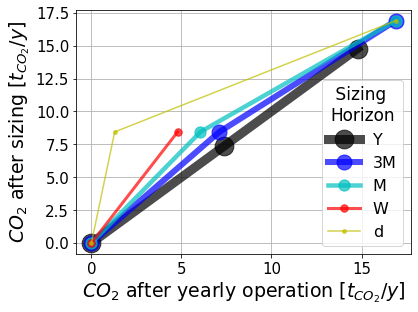

In [82]:
visualize_carbon_paper(root, building='SmallOffice',city='Houston', scenario=7)

# 3. Visualize Battery operation

In [83]:
def get_ope(root, building, city, scenario):
    # Get file paths
    path = root+f"{building}/{city}/Scenario{scenario}/"
    files = sorted([k for k in os.listdir(path) if ((k[:9]=='operation')&(k.find("_sizes")==-1))])
    
    # Load files
    results = {k:{"full":None, "period":None} for k in ['full','3M','M','W','d']} # Initialize results
    for f in files:
        categ = f.split("_")[1].replace(".pkl","").replace('ope','').replace("perOpe","")
        if f.find("perOpe")==-1:
            with open(path+f, 'rb') as sol:
                results[categ]['full'] = pkl.Unpickler(sol).load()
        else:
            with open(path+f, 'rb') as sol:
                results[categ]['period'] = pkl.Unpickler(sol).load()
                
        results['full']['period'] = results['full']['full']
    
    return results

In [84]:
def visualize_battery_operation(root, building, city, scenario):
    ope = get_ope(root, city=city, building=building,scenario=scenario)
    sizes = get_sizes(root, city=city, building=building,scenario=scenario)
    
    columns = [f"Full{k}" for k in list(ope['full']['full'].keys())]+[f"Period{k}" for k in list(ope['full']['period'].keys())]
    averages = pd.DataFrame(None, index=ope.keys(), columns=columns, dtype='float32')
    
    for r in ope:
        fig,axes = plt.subplots(1,2*len(ope[r]['full']),figsize=(25,3))
        for i,ax in enumerate(axes):
            case = ['full','period'][int(i>=len(ope[r]['full']))]
            
            sns.heatmap( ope[r][case][i%3].loc[:,'Battery_SOC'].fillna(0).values.reshape((365,24)).T, ax=ax, vmin=0, vmax=max(.1,sizes[r].loc['Battery',i%3]))
            ax.set_title(f"{city} - {building} - S{scenario}\n([{r.upper()}] SOC for $CO_2$ {len(ope[r][case])-i%3}/{len(ope[r][case])})")
            ax.set_xlabel("Day of year",fontsize=11)
            ax.set_ylabel("Hour of the day",fontsize=11)
            averages.loc[r,columns[i]] = ope[r][case][i%3].loc[:,'Battery_SOC'].mean()
            
        
        plt.plot([.5,.5],[.1,.9],transform=plt.gcf().transFigure, clip_on=False)
        plt.tight_layout()
        plt.show()
    return averages

# 4. Visualize difference in Battery operation

In [85]:
def get_ope_evolution(root, building, city, scenario):
    # Get file paths
    path = root+f"{building}/{city}/Scenario{scenario}/"
    files = sorted([k for k in os.listdir(path) if ((k[:9]=='operation')&(k.find("_sizes")==-1)&(k.find("_perOpe")==-1))])
    
    # Load files
    results = {k:{} for k in ['full','3M','M','W','d']} # Initialize results
    for f in files:
        categ = f.split("_")[1].replace(".pkl","").replace('ope','')
        if categ=='full':
            with open(path+f, 'rb') as sol:
                results[categ]['original'] = pkl.Unpickler(sol).load()
                results[categ]['opePeriod'] = results[categ]['original'] # Operation on each period
                results[categ]['opeFull'] = results[categ]['original'] # Operation on full time series
        else:
            with open(path+f, 'rb') as sol: # FULL OPERATION
                results[categ]['opeFull'] = pkl.Unpickler(sol).load()
            with open(path+f.replace('_ope','_perOpe'), 'rb') as sol: # OPERATION PER PERIODS
                results[categ]['opePeriod'] = pkl.Unpickler(sol).load()
            with open(path+f.replace('_ope','_sizes'), 'rb') as sol: # ORIGINAL OPERATION
                results[categ]['original'] = pkl.Unpickler(sol).load()
            
            for k in results[categ]["original"]:
                results[categ]["original"][k].reset_index(drop=True,inplace=True) # Drop the dates...
    
    return results

In [86]:
def visualize_battery_operation(root, building, city, scenario):
    ope = get_ope(root, city=city, building=building,scenario=scenario)
    sizes = get_sizes(root, city=city, building=building,scenario=scenario)
    
    columns = [f"Full{k}" for k in list(ope['full']['full'].keys())]+[f"Period{k}" for k in list(ope['full']['period'].keys())]
    averages = pd.DataFrame(None, index=ope.keys(), columns=columns, dtype='float32')
    
    for r in ope:
        fig,axes = plt.subplots(1,2*len(ope[r]['full']),figsize=(25,3))
        for i,ax in enumerate(axes):
            case = ['full','period'][int(i>=len(ope[r]['full']))]
            
            sns.heatmap( ope[r][case][i%3].loc[:,'Battery_SOC'].fillna(0).values.reshape((365,24)).T, ax=ax, vmin=0, vmax=max(.1,sizes[r].loc['Battery',i%3]))
            ax.set_title(f"{city} - {building} - S{scenario}\n([{r.upper()}] SOC for $CO_2$ {len(ope[r][case])-i%3}/{len(ope[r][case])})")
            ax.set_xlabel("Day of year",fontsize=11)
            ax.set_ylabel("Hour of the day",fontsize=11)
            averages.loc[r,columns[i]] = ope[r][case][i%3].loc[:,'Battery_SOC'].mean()
            
        
        plt.plot([.5,.5],[.1,.9],transform=plt.gcf().transFigure, clip_on=False)
        plt.tight_layout()
        plt.show()
    return averages

In [87]:
def visual_compare_battery(root, city, building,scenario):
    opeEv = get_ope_evolution(root, city=city, building=building,scenario=scenario)
    sizes = get_sizes(root, city=city, building=building,scenario=scenario)

    for r in sizes:
        fig,axes = plt.subplots(3,sizes[r].shape[1],figsize=(15,7.5))
        for i in range(axes.shape[1]):
            
            sns.heatmap( opeEv[r]['opeFull'][i].loc[:,'Battery_SOC'].fillna(0).values.reshape((365,24)).T, ax=axes[0][i], vmin=0, vmax=max(.1,sizes[r].loc['Battery',i]))
            sns.heatmap( opeEv[r]['original'][i].loc[:,'Battery_SOC'].fillna(0).values.reshape((365,24)).T, ax=axes[1][i], vmin=0, vmax=max(.1,sizes[r].loc['Battery',i]))
            sns.heatmap( opeEv[r]['opePeriod'][i].loc[:,'Battery_SOC'].fillna(0).values.reshape((365,24)).T, ax=axes[2][i], vmin=0, vmax=max(.1,sizes[r].loc['Battery',i]))
            
            axes[0][i].set_title(f"{city} - {building} - S{scenario}\n([{r.upper()}] SOC for $CO_2$ {sizes[r].shape[1]-i}/{sizes[r].shape[1]})")
            axes[0][i].set_xticklabels("")
            axes[1][i].set_xticklabels("")
            axes[2][i].set_xlabel("Day of year",fontsize=11)
            
        axes[0][0].set_ylabel("Full Operation",fontsize=15)
        axes[1][0].set_ylabel("Original",fontsize=15)
        axes[2][0].set_ylabel("Period Operation",fontsize=15)
        
        plt.tight_layout()
        plt.show()

In [161]:
def visual_compare_battery_paper(root, city, building,scenario, carbon, horizon):
    opeEv = get_ope_evolution(root, city=city, building=building,scenario=scenario)[horizon]
    sizes = get_sizes(root, city=city, building=building,scenario=scenario)[horizon]
    
    xticks = (np.linspace(0,365,12, endpoint=False, dtype=int),
              ['Jan','Feb','Mar','Apr','May','June','Juy','Aug','Sept','Oct','Nov','Dec'])
    
    duration = {'full':"yearly", '3M':'3 months', 'M': 'monthly', 'W':'weekly', 'd':'daily'}
    
    
    fig,axes = plt.subplots(3,1,figsize=(7,9.8))
    axes = axes.ravel()

    sns.heatmap( opeEv['original'][carbon].loc[:,'Battery_SOC'].fillna(0).values.reshape((365,24)).T, ax=axes[0],
                vmin=0, vmax=max(.1,sizes.loc['Battery',carbon]),cbar_kws={'label':'Battery SOC (kWh)'})
    sns.heatmap( opeEv['opeFull'][carbon].loc[:,'Battery_SOC'].fillna(0).values.reshape((365,24)).T, ax=axes[1],
                vmin=0, vmax=max(.1,sizes.loc['Battery',carbon]),cbar_kws={'label':'Battery SOC (kWh)'})
    sns.heatmap( opeEv['opePeriod'][carbon].loc[:,'Battery_SOC'].fillna(0).values.reshape((365,24)).T, ax=axes[2],
                vmin=0, vmax=max(.1,sizes.loc['Battery',carbon]),cbar_kws={'label':'Battery SOC (kWh)'})
    
    for i,ax in enumerate(axes):
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        ax.set_xticks((xticks[0]+15)[::2])
        if i==2: ax.set_xticklabels(xticks[1][::2], rotation=0)
        else: ax.set_xticklabels("")
        
        ax.set_yticks((np.arange(0,24)+.5)[::3])
        ax.set_yticklabels(np.arange(0,24,3))
        ax.set_ylabel("Time of day",fontsize=15)
        
        # Colorbar
        ax.figure.axes[-(i+1)].yaxis.label.set_size(15) # Legend
        ax.figure.axes[-(i+1)].tick_params(axis='y',which='major',labelsize=14) # Ticks
        
        
    title_font = 18
    axes[0].set_title(f"After independent {duration[horizon]} sizings",fontsize=title_font)
    axes[1].set_title(f"Once operated with yearly horizon",fontsize=title_font)
    axes[2].set_title(f"After independant {duration[horizon]} operations",fontsize=title_font)
    
    plt.tight_layout()
    plt.savefig(f"../pictures/Horizon_BatOpe_{building[:3]}_{city}_S{scenario}_C{carbon}_{horizon}.png", bbox_inches='tight')
    plt.show()

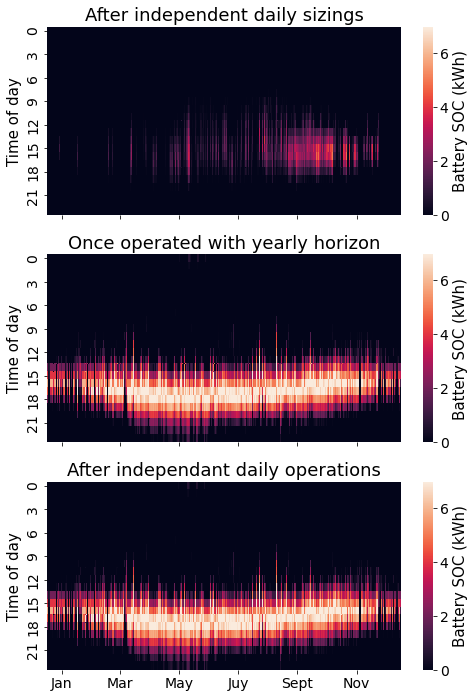

In [162]:
visual_compare_battery_paper(root, city="Baltimore",building='Residential',scenario=6, carbon=1, horizon='d')

# 7. Relative decisive period
Again, we only look at the sizing part, operation is not considered. The principle here is as in part 6: we look at the Reference, that is in Yellow, we look at the sub-periods that are $\pm 5\%$ of that decision in Yellow too. The periods bellow the margin are in blue, the periods above that are in green.

In [168]:
def repeat_series(series, p):
    n_periods = {'full':1, '3M':4, 'M':12, 'W':52, 'd':365}
    
    ranges = pd.date_range('2011',periods=n_periods[p]+1,freq=p)
    repeat = np.array([(ranges[k+1]-ranges[k]).days for k in range(len(ranges)-1)])
    if p=='W': repeat[0]+=1
    
    return np.repeat(series,repeat)

def categorize(series, ref, alpha=.05):
    lim = [(1-alpha)*ref, (1+alpha)*ref]
    return series.apply(lambda x: sum( [int(x>=lim[0]), int(x>lim[1])] ) ) # Open for lower and strict for upper

In [169]:
def get_period_relative(root, building, city, scenario, field='PV', alpha=.05):
    # Get information
    sizesEV = get_sizes_evolution(root, building, city, scenario)
    
    decision = {}
    indexes = pd.date_range('2011',periods=365,freq='d')
    
    # Initialize the repo
    #ref_vals = [ [int(sizesEV['full']['original'][co2].loc[field]>0) for co2 in sizesEV['full']['original']] ]
    decision['full'] = pd.DataFrame(1, index=indexes, columns=sizesEV['full']['original'].keys())
    decision['3M'] = pd.DataFrame(0, index=indexes, columns=sizesEV['3M']['period'].keys(), dtype='int32')
    decision['M'] = pd.DataFrame(0, index=indexes, columns=sizesEV['M']['period'].keys(), dtype='int32')
    decision['W'] = pd.DataFrame(0, index=indexes, columns=sizesEV['W']['period'].keys(), dtype='int32')
    decision['d'] = pd.DataFrame(0, index=indexes, columns=sizesEV['d']['period'].keys(), dtype='int32')
    
    for p in ['3M','M','W','d']:
        for co2 in decision[p].columns:
            peak = sizesEV['full']['original'].loc[field,co2] # identify the reference value
            
            decision[p].loc[:, co2] = categorize(repeat_series(sizesEV[p]['period'][co2].loc[field], p), ref=peak, alpha=alpha).values
                
    return decision

In [170]:
def show_relative(root, building,city, scenario, alpha=.05):
    fields = ['PV','HP','Battery','HWT']
    
    fig,axes = plt.subplots(3,len(fields), figsize=(22,5))
    axes = axes.T
    for j in range(axes.shape[0]):
        moment = get_period_relative(root, building, city, scenario, field=fields[j], alpha=alpha)

        xticks = (np.unique(moment['d'].index.month, return_index=True)[1], 
                  ['Jan','Feb','Mar','Apr','May','June','Juy','Aug','Sept','Oct','Nov','Dec'])
        
        cmap = invert_cmap(lambda x: 1-x, cm.RdYlBu) # Revert the seismic_r gives the best visual.

        axes[j][0].set_title(f"[{building}-{city}-S{scenario}] {fields[j]}",fontsize=13)
        for i,ax in enumerate(axes[j]):
            view = pd.concat( [moment[p].loc[:,i] for p in moment], axis=1 ).T
            view.index = moment.keys()
            sns.heatmap(view, vmin=0, vmax=2, cmap=cmap,ax=ax, cbar=True)
            ax.grid()
            ax.set_ylabel(f"CO2 level {i}")
            ax.set_xticks(xticks[0],)
            ax.set_xticklabels(np.full(len(xticks[0]),""),rotation=0)

        ax.set_xticks(xticks[0])
        ax.set_xticklabels(xticks[1])
    plt.tight_layout()
    plt.show()

In [171]:
def count_relative(root,city, alpha=.05):
    fields = ['PV','HP','Battery']
    horizon = ['3M0','M0','W0','d0',
               '3M1','M1','W1','d1',
               '3M2','M2','W2','d2']
    output = pd.DataFrame(0, index=horizon, columns=fields,)
    
    ### FOR ALL SCENARIOS
    for scenario in range(5,9,1): # Scenario 5 to 8
        ### FOR ALL BUILDINGS:
        for building in ['Residential','SmallOffice']:
            ### FOR EACH TECHNOLOGY
            for i,tech in enumerate(fields):
                moment = get_period_relative(root, building, city, scenario, field=tech, alpha=alpha) # Get initial information
                
                ### FOR EACH CARBON LEVEL
                for j in range(3): # 3 CO2 levels
                    view = pd.concat( [moment[p].loc[:,j] for p in moment], axis=1 ).T # Group per horizon
                    view.index = moment.keys()

                    rows = pd.Index(['3M','M','W','d']) + str(j) # Name of the column
                    ref = view.loc['full'].max() # 0 if not installed, 1 otherwise

                    output.loc[rows,tech] += view.loc['3M':'d'].apply(lambda x: (x==ref).astype('int32').max(),axis=1).values
            
    return output

In [172]:
all_counts = pd.concat([count_relative(root,city=c, alpha=.1)
                        for c in ['Duluth','Seattle','Baltimore','LosAngeles','Houston']],
                       axis=1)

In [173]:
print((all_counts/8).round(2).to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} &    PV &    HP &  Battery &    PV &    HP &  Battery &    PV &    HP &  Battery &    PV &    HP &  Battery &    PV &    HP &  Battery \\
\midrule
3M0 &  0.50 &  0.88 &     0.50 &  0.62 &  1.00 &     0.50 &  0.50 &  0.88 &     0.50 &  0.00 &  0.88 &     0.50 &  0.00 &  0.62 &     0.50 \\
M0  &  0.50 &  0.62 &     0.50 &  0.62 &  0.88 &     0.62 &  0.50 &  0.75 &     0.50 &  0.00 &  0.75 &     0.50 &  0.00 &  0.62 &     0.50 \\
W0  &  0.50 &  0.50 &     0.00 &  0.62 &  0.62 &     0.25 &  0.50 &  0.62 &     0.00 &  0.00 &  0.75 &     0.00 &  0.00 &  0.62 &     0.00 \\
d0  &  0.50 &  0.50 &     0.25 &  0.62 &  0.62 &     0.62 &  0.50 &  0.62 &     0.25 &  0.00 &  0.75 &     0.25 &  0.00 &  0.62 &     0.25 \\
3M1 &  0.38 &  0.50 &     0.25 &  0.38 &  0.50 &     0.50 &  0.38 &  0.75 &     0.25 &  0.12 &  1.00 &     0.12 &  0.00 &  1.00 &     0.00 \\
M1  &  0.25 &  0.88 &     0.25 &  0.62 &  1.00 &     0.12 &  0.12 &  0.75 &     0.38 &  0.00 &  1

In [174]:
(all_counts/8).round(2)

PV    HP  Battery    PV    HP  Battery    PV    HP  Battery    PV  \
3M0  0.50  0.88     0.50  0.62  1.00     0.50  0.50  0.88     0.50  0.00   
M0   0.50  0.62     0.50  0.62  0.88     0.62  0.50  0.75     0.50  0.00   
W0   0.50  0.50     0.00  0.62  0.62     0.25  0.50  0.62     0.00  0.00   
d0   0.50  0.50     0.25  0.62  0.62     0.62  0.50  0.62     0.25  0.00   
3M1  0.38  0.50     0.25  0.38  0.50     0.50  0.38  0.75     0.25  0.12   
M1   0.25  0.88     0.25  0.62  1.00     0.12  0.12  0.75     0.38  0.00   
W1   0.50  0.75     0.38  0.62  0.88     0.38  0.25  0.88     0.50  0.38   
d1   0.62  0.88     0.62  0.75  1.00     0.50  0.75  0.88     0.75  0.75   
3M2  0.50  0.50     1.00  1.00  1.00     1.00  1.00  0.50     0.50  1.00   
M2   0.50  0.00     1.00  1.00  0.50     1.00  1.00  0.50     1.00  0.00   
W2   1.00  0.50     1.00  1.00  0.50     1.00  1.00  1.00     1.00  0.00   
d2   1.00  0.50     1.00  1.00  0.50     1.00  1.00  1.00     1.00  1.00   

       HP  Battery    PV    HP  Battery  
3M0  0.88     0.50  0.00  0.62     0.50  
M0   0.75     0.50  0.00  0.62     0.50  
W0   0.75     0.00  0.00  0.62     0.00  
d0   0.75     0.25  0.00  0.62     0.25  
3M1  1.00     0.12  0.00  1.00     0.00  
M1   1.00     0.38  0.12  1.00     0.00  
W1   0.75     0.12  0.62  1.00     0.00  
d1   1.00     0.75  1.00  1.00     0.25  
3M2  1.00     1.00  0.50  1.00     1.00  
M2   0.50     1.00  0.50  0.50     1.00  
W2   0.50     1.00  0.50  0.50     1.00  
d2   0.50     1.00  1.00  0.50     1.00

In [243]:
def show_relative_paper(root, building, city, scenario, field='PV', alpha=.05):
    
    ### Gather the relative decision
    moment = get_period_relative(root, building=building,city=city, scenario=scenario, field=field, alpha=alpha)
    
    ### Create labels
    titles = {0:'Minimum Cost', 1:'-50% CO$_2$', 2:'Net Zero'}
    xticks = (np.unique(moment['d'].index.month, return_index=True)[1],
              pd.Index(['Jan','Feb','Mar','Apr','May','June','Juy','Aug','Sept','Oct','Nov','Dec']))
    legends =  {'full':'Y', '3M':'3M', 'M':'M','W':'W','d':'d'}
    
    ### Create the adapted tables
    fig,axes = plt.subplots(3,1,figsize=(6,6))
    axes = axes.ravel()
    
    for i,ax in enumerate(axes):
        # Create table
        view = pd.concat( [moment[p].loc[:,i] for p in moment], axis=1 ).T # Gather all for each CO2 level
        view.index = [legends[k] for k in moment.keys()] # Set axes again
        
        
        # Create ticks
        ticks=np.arange(0,3 ) # Create a range of values
        ticklabels = ['Low', f'$\pm${int(100*alpha)}%', 'High']
        boundaries = np.arange(view.values.min()-.5,view.values.max()+1.5 ) # Create cbar limits
        cmap = plt.get_cmap(invert_cmap(lambda x:1-x, cm.RdYlBu),
                            view.values.max()-view.values.min()+1) # Create the colormap
        
        ### Draw the graph
        sns.heatmap(view, vmin=0, vmax=2, cmap=cmap, ax=ax,
                    cbar_kws={"ticks":ticks, "boundaries":boundaries})
        
        ### Customize colorbar
        lowest = view.values.min() # Get the overall minimum in the figure to match colorbar label
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks(ticks)
        c_bar.ax.set_yticklabels(ticklabels[lowest:], rotation=90, verticalalignment='center',fontsize=11.5)
        
        ax.set_title(titles[i], fontsize=15)
        ax.set_xticks(xticks[0])
        ax.set_xticklabels('         '+xticks[1], rotation=0)
        
        ax.set_yticks(1+np.arange(view.shape[0]))
        ax.set_yticklabels(view.index+"\n", rotation=0,fontsize=12)
        
        ax.grid()
    plt.tight_layout()
    plt.savefig(f"../pictures/Horizon_{building[:3]}_{city}_S{scenario}_{field[:3]}.png", bbox_inches='tight')
    plt.show()

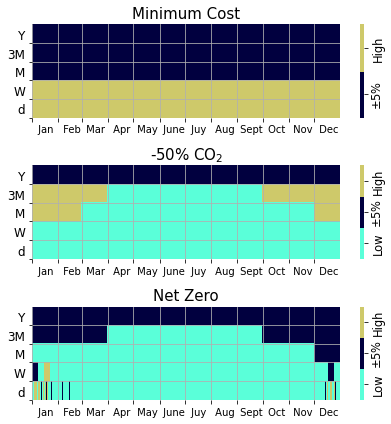

In [244]:
show_relative_paper(root, building='Residential', city='Baltimore', scenario=7, field='Battery', alpha=.05)

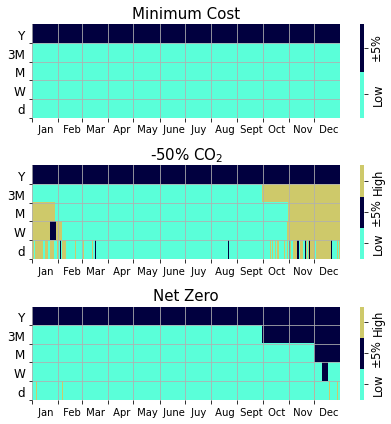

In [245]:
show_relative_paper(root, building='SmallOffice', city='Seattle', scenario=6, field='PV', alpha=.05)

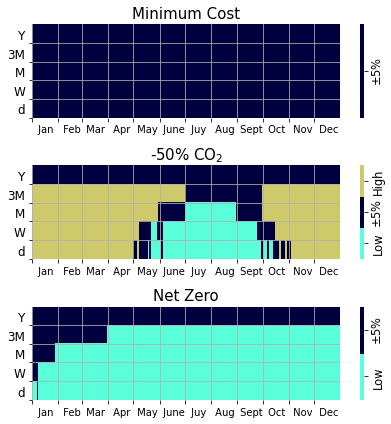

In [246]:
show_relative_paper(root, building='Residential', city='LosAngeles', scenario=6, field='HP', alpha=.05)

# 8. Periodic decision
Similar as before, only sizing is considered. Difference with §7 are the now continuous values for relative importance.

In [33]:
def repeat_series(series, p):
    n_periods = {'full':1, '3M':4, 'M':12, 'W':52, 'd':365}
    
    ranges = pd.date_range('2011',periods=n_periods[p]+1,freq=p)
    repeat = np.array([(ranges[k+1]-ranges[k]).days for k in range(len(ranges)-1)])
    if p=='W': repeat[0]+=1
    
    return np.repeat(series,repeat)

def resize(series, ref=None):
    if ref is None: # Resize based on own maximum
        return series / series.max() # Only-max sizing (guess the importance of error)
    else:
        return series / ref

In [34]:
def get_period_decision(root, building, city, scenario, field='PV'):
    # Get information
    sizesEV = get_sizes_evolution(root, building, city, scenario)
    
    decision = {}
    indexes = pd.date_range('2011',periods=365,freq='d')
    
    # Initialize the repo
    ref_vals = [ [int(sizesEV['full']['original'][co2].loc[field]>0) for co2 in sizesEV['full']['original']] ]
    decision['full'] = pd.DataFrame(ref_vals, index=indexes, columns=sizesEV['full']['original'].keys())
    decision['3M'] = pd.DataFrame(None, index=indexes, columns=sizesEV['3M']['period'].keys(), dtype='float32')
    decision['M'] = pd.DataFrame(None, index=indexes, columns=sizesEV['M']['period'].keys(), dtype='float32')
    decision['W'] = pd.DataFrame(None, index=indexes, columns=sizesEV['W']['period'].keys(), dtype='float32')
    decision['d'] = pd.DataFrame(None, index=indexes, columns=sizesEV['d']['period'].keys(), dtype='float32')
    
    for p in ['3M','M','W','d']:
        for co2 in decision[p].columns:
            peak = sizesEV['full']['original'][co2].loc[field].max() # identify the reference value
            if peak>0:
                decision[p].loc[:, co2] = resize(repeat_series(sizesEV[p]['period'][co2].loc[field].values, p), ref=peak)
        decision[p].fillna(0,inplace=True)
    return decision

In [35]:
def show_decision(root, building,city, scenario):
    fields = ['PV','HP','Battery','HWT']
    
    fig,axes = plt.subplots(3,len(fields), figsize=(22,4.5))
    axes = axes.T
    for j in range(axes.shape[0]):
        moment = get_period_decision(root, building, city, scenario, field=fields[j])

        xticks = (np.unique(moment['d'].index.month, return_index=True)[1], 
                  ['Jan','Feb','Mar','Apr','May','June','Juy','Aug','Sept','Oct','Nov','Dec'])
        
        cmap = invert_cmap(lambda x: 1-x, cm.seismic_r) # Revert the seismic_r gives the best visual.

        axes[j][0].set_title(f"[{building}-{city}-S{scenario}] {fields[j]}",fontsize=13)
        for i,ax in enumerate(axes[j]):
            view = pd.concat( [moment[p].loc[:,i] for p in moment], axis=1 ).T
            view.index = moment.keys()
            sns.heatmap(view, vmin=0, center=1, vmax=max(1, view.values.max()), cmap=cmap,ax=ax, cbar=True)
            ax.grid()
            ax.set_ylabel(f"CO2 level {i}")
            ax.set_xticks(xticks[0],)
            ax.set_xticklabels(np.full(len(xticks[0]),""),rotation=0)

        ax.set_xticks(xticks[0])
        ax.set_xticklabels(xticks[1])
    plt.tight_layout()
    plt.show()

# 8. Investigate the computation time

In [247]:
def get_durations(root, building, city, scenario, kind='Full'):
    """Gather the computation time for the whole exercise.
    Parameter:
    ----------
        kind: str. default 'Full'
            Design the kind of exercise. Can be 'Full' or 'Part'
    """
    
    sizesEv = get_sizes_evolution(root, building, city, scenario)
    
    durations = pd.DataFrame(0, index=['Size Create','Size Solver','Ope Create','Ope Solver',],
                             columns=['full','3M','M','W','d'], dtype='float32')
    
    for k in durations:
        when = 'original'
        durations.loc['Size Solver',k] = sizesEv[k][when].loc['time_solver'].mean()
        durations.loc['Size Create',k] = (sizesEv[k][when].loc['time_total'] - sizesEv[k][when].loc['time_solver']).mean()

        if k=='full': continue;
        when = f'ope{kind}'
        durations.loc['Ope Solver',k] = sizesEv[k][when].loc['time_solver'].mean()
        durations.loc['Ope Create',k] = (sizesEv[k][when].loc['time_total'] - sizesEv[k][when].loc['time_solver']).mean()
        
    return durations

In [248]:
def get_overall_duration(root, building, kind='Full'):
    """Gather the computation time for the whole exercise.
    Parameter:
    ----------
        kind: str. default 'Full'
            Design the kind of exercise. Can be 'Full' or 'Part'
    """
    
    cities = ['Duluth','Seattle','Baltimore','LosAngeles','Houston']
    scenarios = [5,6,7,8]
    
    all_durations = [] # List to fill
    
    for c in cities:
        for s in scenarios:
            duration = get_durations(root, building=building, city=c, scenario=s, kind=kind)
            all_durations.append(100*duration/duration.loc[:,'full'].sum()) # Add in % to the list
    
    average = pd.DataFrame( np.mean(all_durations,axis=0), index=all_durations[0].index, columns=all_durations[0].columns ) # Average all times
    std = pd.DataFrame( np.std(all_durations,axis=0), index=all_durations[0].index, columns=all_durations[0].columns ) # STD all times
    
    tot_average = pd.concat([ad.sum() for ad in all_durations],axis=1).T
    
    return average, std, tot_average

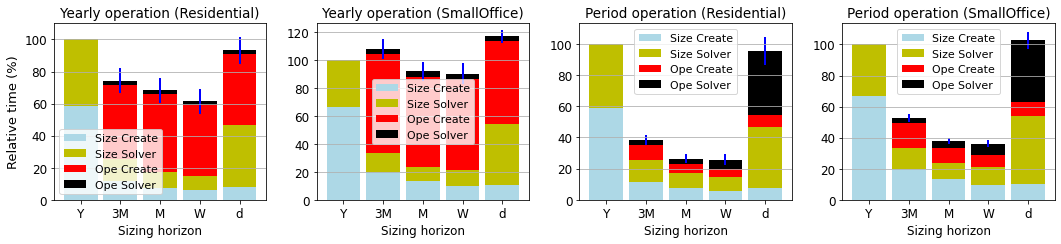

In [259]:
fig,axes = plt.subplots(1,4,figsize=(15,3.5))
buildings = ['Residential','SmallOffice','Residential', 'SmallOffice']
kinds = ['Full','Full','Part','Part']
legend_position = ['lower left', 'center', 'upper center', 'upper center']
legends =  {'full':'Y', '3M':'3M', 'M':'M','W':'W','d':'d'}
titles = {'Full':'Yearly operation', 'Part':'Period operation'}

for i,ax in enumerate(axes):
    avg,std,tot_avg = get_overall_duration(root, building=buildings[i],kind=kinds[i])
    avg.T.plot(kind='bar', width=.85, stacked=True, color=['lightblue','y','r','k',], ax=ax).legend(ncol=1, loc=legend_position[i],fontsize=11)
    ax.bar(x=avg.columns, height=tot_avg.std(), bottom=(avg.sum()-tot_avg.std()/2), width=.05, color="b")
    
    ax.set_ylim([0,max(110, (avg.sum()+tot_avg.std()).max())])
    if i==0: ax.set_ylabel("Relative time (%)",fontsize=13)
    
    ax.set_xticks(range(avg.shape[1]))
    ax.set_xticklabels([legends[c] for c in avg.columns], rotation=0)
    ax.set_xlabel('Sizing horizon',fontsize=12)
    
    ax.set_title(f"{titles[kinds[i]]} ({buildings[i]})",fontsize=13.5)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    ax.grid(axis="y")
    
plt.tight_layout()
plt.savefig("../pictures/Horizon_Time.png",bbox_inches='tight')
plt.show()

# 9. Binding constraints

Binding constraints are the decisive constraints. Locating them is already a first clue what the model is doing. There are *general constraints* (time independent) and *timed constraints* (one per time step). We focus on the ***inequality constraints*** that are ***in an equality state***:
+ output of a tech (except PV) equal its capacity [For HP only]
+ storage ramping [For Battery and HWT]
+ storage max capacity [For Battery and HWT]

A goal is to use the models meaning / interpretability to visualize what these binding constraints mean (and how far from being binding all other are). However for the PV, something else must be found, as no binding constraint exist and only the links to price and carbon can be made (which is a sum of all time steps, so a minor contribution...)

## 9.1 Heat Pump

In [39]:
def get_ope_hp(root,city,building,scenario, loads):
    # Get the operations
    ope = get_ope_evolution(root, building=building, city=city, scenario=scenario)
    
    output_HP = {co2: pd.DataFrame(None, columns=ope.keys(),index=pd.date_range(start="2011",freq="H",periods=8760),dtype='float32')
                 for co2 in ope['full']['original']}
    
    # Do the calculus of HP usage
    for p in ope:
        for co2 in ope[p]['original']: # Extract only the operation related to sizing for now
            HWT_var = -np.diff(np.concatenate([ope[p]['original'][co2].loc[:,'HWT_SOC'].fillna(np.nan).values,
                                               ope[p]['original'][co2].loc[:,'HWT_SOC'].fillna(np.nan).values[:1],]))
            boil_out = ope[p]['original'][co2].loc[:,'from_Gas'].fillna(np.nan).values * .95

            output_HP[co2].loc[:,p] = loads[building].loc[:,'Heat'].values - boil_out - HWT_var
    return output_HP

In [40]:
def binding_hp(root,city,building,scenario):
    ### GATHER THE DATA
    loads = get_building_load(city=city)
    output = get_ope_hp(root,city,building,scenario,loads)
    sizes = get_sizes_evolution(root, city=city,building=building, scenario=scenario)
    horizon = list(sizes.keys())
    
    count = {"3M":lambda i: np.unique(output[i].index.quarter),"M":lambda i: np.unique(output[i].index.month),
             "W":lambda i: np.unique(pd.Int64Index(output[i].index.isocalendar().week)),"d":lambda i: np.unique(output[i].index.dayofyear)}
    localize = {"3M":lambda i,g: output[i].index.quarter==g,"M":lambda i,g: output[i].index.month==g,
                "W":lambda i,g: pd.Int64Index(output[i].index.isocalendar().week)==g,"d":lambda i,g: output[i].index.dayofyear==g}
    
    carbon_levels = range(sizes['full']['original'].shape[1])
    points = {'full':{co2:[] for co2 in carbon_levels},
              '3M':{co2:[] for co2 in carbon_levels},
              'M':{co2:[] for co2 in carbon_levels},
              'W':{co2:[] for co2 in carbon_levels},
              'd':{co2:[] for co2 in carbon_levels}}
    
    for i in carbon_levels: # for each row (carbon level)
        upper = output[i].max().max()
        for j in range(len(sizes)):
            if horizon[j]=='full':### FULL
                view = output[i].loc[:,'full']
                points['full'][i] = pd.DataFrame(view.loc[((view>=view.max())&(view.round(8)!=0))].rename("HP"))
                points['full'][i]['Heat'] = loads[building].loc[:,'Heat'].max()#loads[building].loc[:,'Heat']/loads[building].loc[:,'Heat'].max()

            else:### OTHER TIME HORIZONS
                groups = count[horizon[j]](i) # List of elements to consider
                for g in groups:
                    view = output[i].loc[ localize[horizon[j]](i,g), horizon[j] ]
                    points[horizon[j]][i].append( pd.DataFrame(view[((view>=view.max())&(view.round(8)!=0))].rename("HP")) )
                    heating = loads[building].loc[ localize[horizon[j]](i,g), 'Heat' ] # All points at which constraint is binding
                    points[horizon[j]][i][-1]['Heat'] = heating.max()#heating/heating.max() # Relative importance of the peak in that period
                points[horizon[j]][i] = pd.concat(points[horizon[j]][i],axis=0).sort_index()
    return points

In [154]:
def show_hp(root,city,building,scenario, alpha=.05, horizon=None, carbon=None, flip=False, is_sorted=False):
    
    
    ### GATHER THE DATA
    loads = get_building_load(city=city)
    output = get_ope_hp(root,city,building,scenario, loads=loads)
    sizes = get_sizes_evolution(root, city=city,building=building, scenario=scenario)
    
    if horizon is None: horizon = ['full','3M','M','W','d']
    if carbon is None: carbon = sizes['full']['original'].columns
    duration = {'full': 'Yearly', '3M':'3 months', 'M': 'Monthly', 'W': 'Weekly', "d": 'Daily'}
    
    count = {"3M":lambda i: np.unique(output[i].index.quarter),"M":lambda i: np.unique(output[i].index.month),
             "W":lambda i: np.unique(pd.Int64Index(output[i].index.isocalendar().week)),"d":lambda i: np.unique(output[i].index.dayofyear)}
    localize = {"3M":lambda i,g: output[i].index.quarter==g,"M":lambda i,g: output[i].index.month==g,
                "W":lambda i,g: pd.Int64Index(output[i].index.isocalendar().week)==g,"d":lambda i,g: output[i].index.dayofyear==g}
    
    ### BUILD THE GRAPH
    if flip:
        fig,axes = plt.subplots(len(horizon), len(carbon), figsize=(4*len(carbon), 3*(len(horizon))))
        axes = axes.T.reshape((len(carbon),len(horizon)))
    else:
        fig,axes = plt.subplots(len(carbon), len(horizon), figsize=(4*len(horizon), 3*(len(carbon))))
        axes = axes.reshape((len(carbon),len(horizon)))
    
    for i,co2 in zip(range(axes.shape[0]),carbon): # for each row (carbon level)
        upper = output[co2].max().max() # For calibrating the image height
        full_size = sizes['full']['original'].loc['HP',co2]
        for j,ax in enumerate(axes[i]):
            topLine = 0 # Reset the top line
            
            if horizon[j]=='full':### FULL
                if is_sorted:
                    view = output[co2].loc[:,'full'].sort_values().reset_index(drop=True)
                else:
                    view = output[co2].loc[:,'full'].reset_index(drop=True)
                    
                view.plot(ax=ax,grid=True, alpha=.8)
                l_dot = ax.plot([view.idxmax()],[sizes['full']['original'].loc['HP',co2]], linestyle="", marker="o", c="k", ms=5, label='Binding')
                    
                length = output[i].shape[0]-1
                topLine = view.values.max()

            else:### OTHER TIME HORIZONS
                groups = count[horizon[j]](co2) # List of elements to consider
                length=0
                for g in groups:
                    if is_sorted:
                        view = output[co2].loc[ localize[horizon[j]](co2,g) ,horizon[j]].sort_values().reset_index(drop=True)
                    else:
                        view = output[co2].loc[ localize[horizon[j]](co2,g) ,horizon[j]].reset_index(drop=True)
                    l_dot = ax.plot([view.idxmax()],[sizes[horizon[j]]['period'][co2].loc['HP',g-1]], linestyle="", marker="o", c="k", ms=5, label="Binding")
                    view.plot(ax=ax,grid=True, alpha=.4)
                    length = max(length, view.shape[0]-1)
                    topLine = max(topLine, view.values.max())
            
            ax.set_ylim([-.1, max(1,(1+2*alpha)*upper)])
            l_margin = ax.fill_between(x=[0,length], y1=[(1-alpha)*full_size]*2, y2=[(1+alpha)*full_size]*2,
                                       alpha=.2, color='r', label='$\pm 5\%$ margin') # Bound for accurate sizing
            l_cap = ax.hlines(topLine, 0,length, linestyle='dotted',color="k", label="Max capacity")
            
            if j==0:
                lines = l_dot+[l_margin, l_cap]
                ax.legend(lines, [l.get_label() for l in lines], fontsize=11)
            
            if flip:
                ax.set_title(f"{duration[ horizon[j] ]} horizon",fontsize=14)
                ax.set_xlabel("Timesteps (in hour)",fontsize=11)
                if i==0: ax.set_ylabel("HP output [kW$_{th}$]",fontsize=12)
            else:
                if i==0: ax.set_title(f"{duration[ horizon[j] ]} horizon",fontsize=14)
                if i+1==len(carbon): ax.set_xlabel("Timesteps (in hour)",fontsize=11)
                if j==0: ax.set_ylabel("HP output [kW$_{th}$]",fontsize=12)
            
    plt.tight_layout()
    plt.savefig(f"../pictures/Horizon_HPBind_{building[:3]}_{city}_S{scenario}_C{carbon[0]}.png", bbox_inches='tight')
    plt.show();

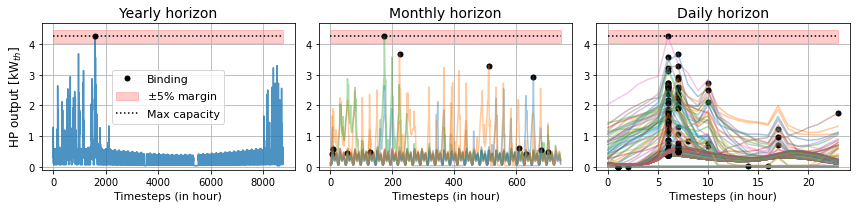

In [42]:
show_hp(root, city='Houston', building='Residential', scenario=7, horizon=['full','M','d'], carbon=[1], alpha=.05)

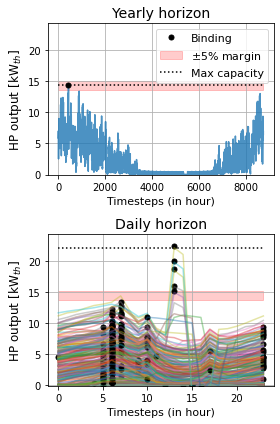

In [155]:
show_hp(root, city='Baltimore', building='Residential', scenario=5, horizon=['full','d'], carbon=[2], alpha=.05, flip=True)

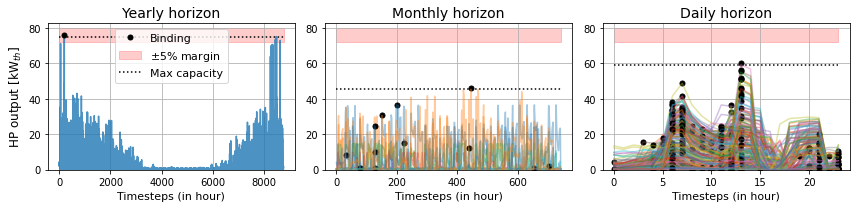

In [130]:
show_hp(root, city='Duluth', building='SmallOffice', scenario=5, horizon=['full','M','d'], carbon=[2], alpha=.05)

## Linear Regression -> Maybe only in the presentation.

In [102]:
### EVERYTHING AT ONCE
t0 = time()
out = []
for c in ['Duluth','Seattle','Baltimore','LosAngeles','Houston']:
    for b in ['Residential','SmallOffice']:
        for s in range(5,9):
            print(f"({time()-t0:.1f} sec) {c}>{b}; Scenario{s}     ",end="\r")
            
            points = binding_hp(root, city=c,building=b,scenario=s)

            for h in points:
                for co2 in points[h]:
                    points[h][co2]['Scenario'] = s
                    points[h][co2]['Building'] = b
                    points[h][co2]['City'] = c
            out.append( points )
print(f"done. ({(time()-t0)//60:.1f} min)                                       ")

done.                                             


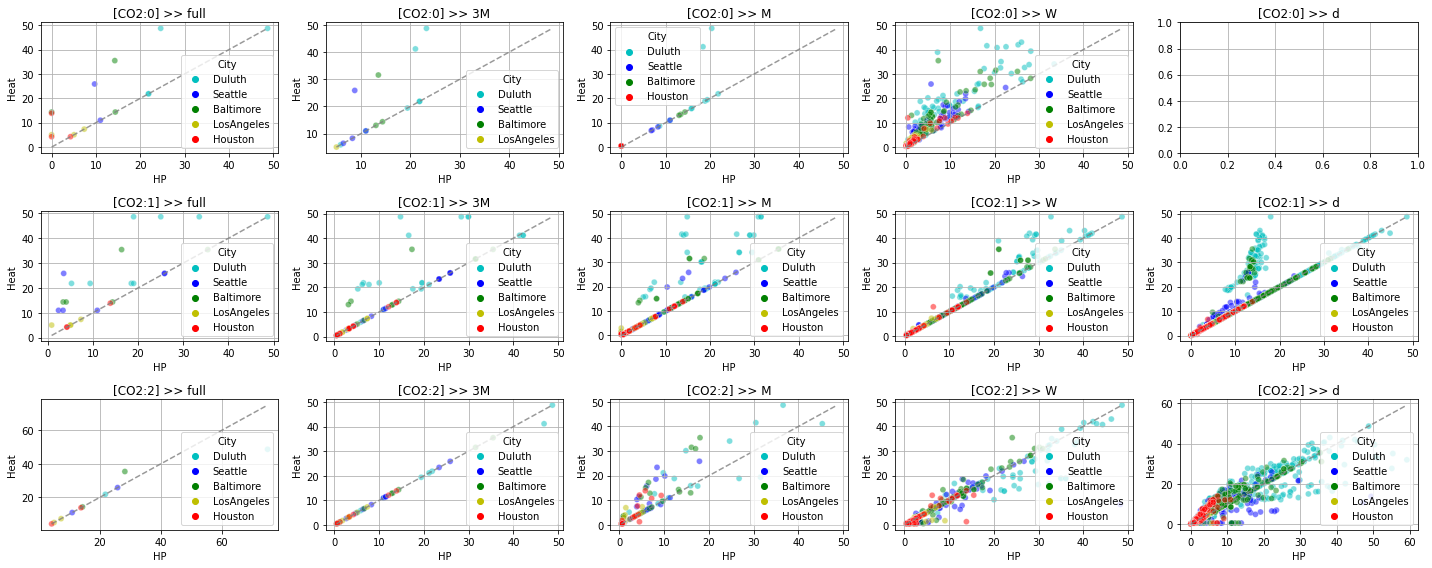

In [103]:
horizons = ['full','3M','M','W','d']
colors = {'Duluth':'c', 'Seattle':'b', 'Baltimore':'g', 'LosAngeles':'y', 'Houston':'r'}

fig,axes = plt.subplots(3,5,figsize=(20,8))
for co2,row in enumerate(axes):
    for j,ax in enumerate(row):
        view = pd.DataFrame( np.concatenate([o[horizons[j]][co2].values for o in out],axis=0),
                            columns=['HP','Heat','Scenario','Building','City']  ).drop_duplicates(subset=['HP','Heat'], ignore_index=True)
        sns.scatterplot(data=view, x='HP',y='Heat',hue='City', ax=ax, alpha=.5, palette=colors)
        ax.grid()
        if view.shape[0]>0:
            diag = view.loc[:,['HP','Heat']].values
            ax.plot([diag.min(),diag.max()],[diag.min(),diag.max()],
                    linestyle="--", c='gray', alpha=.8)
        ax.set_title(f"[CO2:{co2}] >> {horizons[j]}",fontsize=12)
plt.tight_layout();

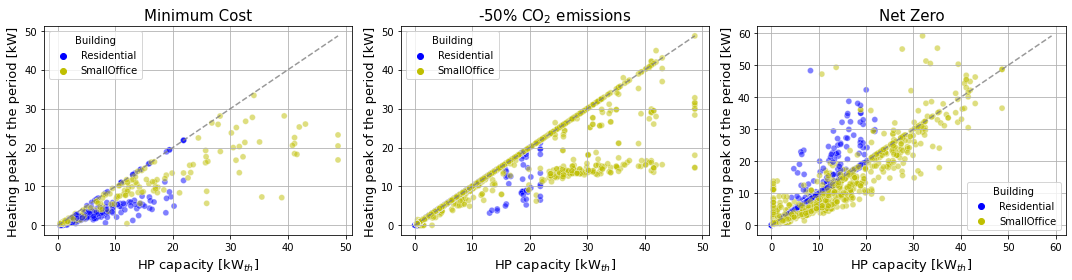

In [104]:
horizons = ['3M','M','W','d']
colors = {'Duluth':'c', 'Seattle':'b', 'Baltimore':'g', 'LosAngeles':'y', 'Houston':'r'}
colors = {'Residential':'b', 'SmallOffice':'y'}
titles = {0:"Minimum Cost", 1: "-50% CO$_2$ emissions", 2: "Net Zero"}

fig,axes = plt.subplots(1,3,figsize=(15,4))
for co2,ax in enumerate(axes):
    #for j,ax in enumerate(row):
    view = pd.DataFrame( np.concatenate([np.concatenate([o[h][co2].values for o in out],axis=0)
                                         for h in horizons],axis=0),
                        columns=['HP','Heat','Scenario','Building','City']  ).drop_duplicates(subset=['HP','Heat'], ignore_index=True)
    sns.scatterplot(data=view, x='Heat',y='HP',hue='Building', ax=ax, alpha=.5, palette=colors)
    ax.grid()
    if view.shape[0]>0:
        diag = view.loc[:,['HP','Heat']].values
        ax.plot([diag.min(),diag.max()],[diag.min(),diag.max()], linestyle="--", c='gray', alpha=.8)
    ax.set_title(titles[co2],fontsize=15)
    ax.set_xlabel("HP capacity [kW$_{th}$]",fontsize=13)
    ax.set_ylabel("Heating peak of the period [kW]",fontsize=13)
plt.tight_layout();

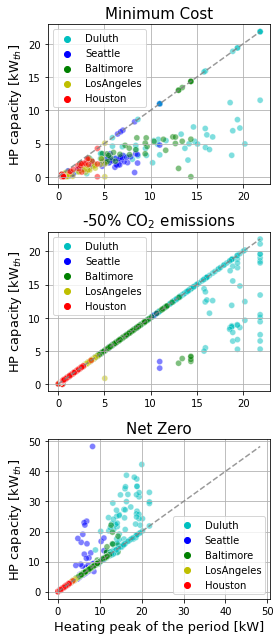

In [153]:
bldg = "Residential"

legend_loc = {0:'upper left',1:'upper left', 2:'lower right'}

horizons = ['full','3M','M','W','d']
colors = {'Duluth':'c', 'Seattle':'b', 'Baltimore':'g', 'LosAngeles':'y', 'Houston':'r'}
#colors = {'Residential':'b', 'SmallOffice':'y'}
titles = {0:"Minimum Cost", 1: "-50% CO$_2$ emissions", 2: "Net Zero"}

fig,axes = plt.subplots(3,1,figsize=(4,9))
for co2,ax in enumerate(axes):
    view = pd.DataFrame( np.concatenate([np.concatenate([o[h][co2].values for o in out],axis=0)
                                         for h in horizons],axis=0),
                        columns=['HP','Heat','Scenario','Building','City']  ).drop_duplicates(subset=['HP','Heat'], ignore_index=True)
    view = view[view.loc[:,'Building']==bldg] # Sub-selection
    sns.scatterplot(data=view, x='Heat',y='HP',hue='City', ax=ax, alpha=.5, palette=colors).legend(loc=legend_loc[co2])
    ax.grid()
    if view.shape[0]>0:
        diag = view.loc[:,['HP','Heat']].values
        ax.plot([diag.min(),diag.max()],[diag.min(),diag.max()], linestyle="--", c='gray', alpha=.8)
    ax.set_title(f"{titles[co2]}",fontsize=15)
    ax.set_ylabel("HP capacity [kW$_{th}$]",fontsize=13)
    if co2==2:
        ax.set_xlabel("Heating peak of the period [kW]",fontsize=13)
    else: ax.set_xlabel("")
plt.tight_layout()
plt.savefig(f"../pictures/Horizon_HPScatter_{bldg[:3]}.png",bbox_inches='tight')
plt.show()

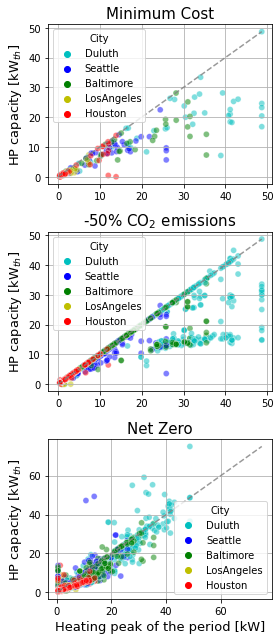

In [150]:
bldg = "SmallOffice"

horizons = ['full','3M','M','W','d']
colors = {'Duluth':'c', 'Seattle':'b', 'Baltimore':'g', 'LosAngeles':'y', 'Houston':'r'}
#colors = {'Residential':'b', 'SmallOffice':'y'}
titles = {0:"Minimum Cost", 1: "-50% CO$_2$ emissions", 2: "Net Zero"}

fig,axes = plt.subplots(3,1,figsize=(4,9))

for co2,ax in enumerate(axes):
    #for j,ax in enumerate(row):
    view = pd.DataFrame( np.concatenate([np.concatenate([o[h][co2].values for o in out],axis=0)
                                         for h in horizons],axis=0),
                        columns=['HP','Heat','Scenario','Building','City']  ).drop_duplicates(subset=['HP','Heat'], ignore_index=True)
    view = view[view.loc[:,'Building']==bldg] # Sub-selection
    sns.scatterplot(data=view, x='Heat',y='HP',hue='City', ax=ax, alpha=.5, palette=colors)
    ax.grid()
    if view.shape[0]>0:
        diag = view.loc[:,['HP','Heat']].values
        ax.plot([diag.min(),diag.max()],[diag.min(),diag.max()], linestyle="--", c='gray', alpha=.8)
    ax.set_title(f"{titles[co2]}",fontsize=15)
    ax.set_ylabel("HP capacity [kW$_{th}$]",fontsize=13)
    if co2==2:
        ax.set_xlabel("Heating peak of the period [kW]",fontsize=13)
    else: ax.set_xlabel("")

plt.tight_layout()
#plt.savefig(f"../pictures/Horizon_HPScatter_{bldg[:3]}.png",bbox_inches='tight')
plt.show()

Mostly points align on the diagonal.

Points above the diagonal show higher heat than HP can handle. It can be from intelligent use of HWT to reduce peak HP demand (at net zero) or mix use of alternative using gas (e.g. -50\% Carbon).

Points below the diagonal are where HWT is loaded abruptly when shining sun in cold places (Duluth and Seattle). All storage charging capacity is then used at the same time and creates a peak of HP usage at 2pm.

## 9.2. Storage Devices
Mostly we focus on the Battery, as the HWT is not installed...

TODO:
+ Similar as above, including the scatter plot
+ one for SOC ; one for ramping up ; one for ramping down

In [44]:
def get_ramping_Bat(root,city,building,scenario):
    
    ope = get_ope_evolution(root=root, building=building,city=city, scenario=scenario)
    
    carbon_levels = list(ope['full']['original'])
    ramping = {'full':{co2:[] for co2 in carbon_levels},
               '3M':{co2:[] for co2 in carbon_levels},
               'M':{co2:[] for co2 in carbon_levels},
               'W':{co2:[] for co2 in carbon_levels},
               'd':{co2:[] for co2 in carbon_levels}}
    
    count = {"3M":lambda data: np.unique(data.index.quarter),"M":lambda data: np.unique(data.index.month),
             "W":lambda data: np.unique(pd.Int64Index(data.index.isocalendar().week)),"d":lambda data: np.unique(data.index.dayofyear)}
    localize = {"3M":lambda data,g: data.index.quarter==g,"M":lambda data,g: data.index.month==g,
                "W":lambda data,g: pd.Int64Index(data.index.isocalendar().week)==g,"d":lambda data,g: data.index.dayofyear==g}
    
    get_ramp = lambda data: (data - (1-0.01)* np.roll(data.values,shift=+1)).round(8).reset_index(drop=True) # Ramping
    
    # Do the calculation for Bat ramping
    for p in ope: # for horizon
        for co2 in ope['full']['original']:
        
            soc = ope[p]['original'][co2].loc[:,'Battery_SOC'] # Gather SOC
            soc.index = pd.date_range(start="2011",periods=soc.shape[0], freq="H")
            
            if p=='full':
                ramping[p][co2] = get_ramp(soc) # Ramping

            else:
                if p=="W": # Correct data fro the week horizon
                    dates = pd.date_range(start='2011',periods=168,freq="H") # 1st week
                    delta = int(pd.Timedelta( pd.to_datetime("2011") - dates[dates.isocalendar().week==1][0] ) / pd.Timedelta("1H")) # in Hours
                    soc = pd.Series( np.roll(soc.values, shift=-delta, axis=0), index=soc.index, name=soc.name ) # Replace data in the SOC
                    
                groups = count[p](soc)
                for g in groups:
                    subsoc = soc[localize[p](soc,g)]
                    ramping[p][co2].append( get_ramp(subsoc) )
                    
        
                # CONCATENATE
                ramping[p][co2] = pd.concat(ramping[p][co2],axis=1)
    return ramping

In [45]:
def binding_ramp(root,city,building,scenario):
    print("Get the load...     ", end="\r")
    loads = get_building_load(city=city)
    
    print("Get the ramping information...     ", end="\r")
    ramp = get_ramping_Bat(root, city=city, building=building, scenario=scenario) # Get the ramping
    
    print("Get the sizes...          ", end="\r")
    sizes = get_sizes_evolution(root, city=city, building=building, scenario=scenario)
    
    print("Compute the points...               ", end="\r")
    localize = {"3M":lambda data,g: data.index.quarter==g,"M":lambda data,g: data.index.month==g,
                "W":lambda data,g: pd.Int64Index(data.index.isocalendar().week)==g,"d":lambda data,g: data.index.dayofyear==g}
    points = {}
    
    for p in ramp: # For each horizon
        points[p] = {co2: [] for co2 in ramp[p].keys()}
        for co2 in ramp[p]: # For all carbon levels
            if p=='full':
                limit_up = ((.3*.96) * sizes[p]['original'].loc['Battery',co2]).round(4) # 30% of max // 96% eff. >> up limit
                limit_down = ((-.3/.96) * sizes[p]['original'].loc['Battery',co2]).round(4) # 30% of max // 96% eff. >> down limit
                
                up = pd.DataFrame(ramp[p][co2][ ((ramp[p][co2].round(4)>=limit_up)&(limit_up!=0)) ].rename("Ramping"))
                down = pd.DataFrame(ramp[p][co2][ ((ramp[p][co2].round(4)<=limit_down)&(limit_down!=0)) ].rename("Ramping"))
                
                points[p][co2].append( add_loads(pd.concat([up,down],axis=0), loads[building], name='Ramping') ) # Add some stats
                
            else:
                limit_up = ((.3*.96) * sizes[p]['period'][co2].loc['Battery',:]).round(4) # up limit
                limit_down = ((-.3/.96) * sizes[p]['period'][co2].loc['Battery',:]).round(4) # down limit
                
                for g in limit_up.index: # Now a series with group# as index
                    subload = loads[building].loc[localize[p](loads[building],g+1),:]
                    
                    view = ramp[p][co2].iloc[:,g].round(4)
                    up = pd.DataFrame(ramp[p][co2][ ((view>=limit_up.loc[g])&(limit_up.loc[g]!=0)) ].iloc[:,g].rename('Ramping'))
                    points[p][co2].append( add_loads(up, subload, name='Ramping') ) # Add some stats
                    
                    down = pd.DataFrame(ramp[p][co2][ ((view<=limit_down.loc[g])&(limit_down.loc[g]!=0)) ].iloc[:,g].rename('Ramping'))
                    points[p][co2].append( add_loads(down, subload, name='Ramping') ) # Add some stats
                    
            points[p][co2] = pd.concat( points[p][co2],axis=0 )
    print("done.                       ")
    return ramp, points

In [46]:
def add_loads(pts, load, name='Ramping'):
    derivate = lambda s: pd.DataFrame(index=s.index, columns="Diff_"+s.columns, data=np.diff( np.concatenate([s.values, s.values[[0],:]],axis=0) , axis=0) )
    peak = lambda s: pd.DataFrame( np.tile( s.max().values, s.shape[0] ).reshape(s.shape), index=s.index, columns="Peak_"+s.columns )
    
    df = pd.concat([load.iloc[pts.index,:],
                    derivate(load).iloc[pts.index,:],
                    peak(load).iloc[pts.index,:]],axis=1)
    df[name] = pts.values
    df.index = pts.index

    return df

In [47]:
def show_ramping(root, city, building, scenario, alpha=.05, horizon=None, carbon=None):
    ramp, points = binding_ramp(root, city=city, building=building, scenario=scenario)
    sizes = get_sizes_evolution(root, city=city, building=building, scenario=scenario)
    
    
    if horizon is None: horizon = list(ramp.keys())
    if carbon is None: carbon = sizes['full']['original'].columns
    duration = {'full': 'Yearly', '3M':'3 months', 'M': 'Monthly', 'W': 'Weekly', "d": 'Daily'}
    
    
    fig,axes = plt.subplots(len(carbon), len(horizon), figsize=(4*len(horizon), 3*(len(carbon))))
    axes = axes.reshape((len(carbon),len(horizon)))
    
    coef_up, coef_down = (.3*.96), (.3/.96)
    
    for co2,row in zip(carbon,axes):
        ### EXTREMUMS
        max_capacity = max([sizes[p]['original'].loc['Battery',co2] for p in sizes])
        ref_capacity = sizes['full']['original'].loc['Battery',co2]
        
        ### MARGINS
        highest = max_capacity * coef_up
        lowest = -max_capacity * coef_down
        
        margin_up = ref_capacity*coef_up * np.array([1+alpha,1-alpha])
        margin_down = -ref_capacity*coef_down * np.array([1+alpha,1-alpha])
        
        
        for p,ax in zip(horizon,row):
            # plotting
            if p=='full': view = ramp[p][co2].copy()
            else:
                view = ramp[p][co2].loc[:,  ramp[p][co2].abs().sum().round(2)>0 ].copy() # Select only if not zero (not overload)
                if view.shape[1]==0: view['data'] = np.nan
                
            view.plot(grid=True,ax=ax, alpha=.5,legend=False)
            l_pts = ax.plot( points[p][co2].index, points[p][co2].loc[:,'Ramping'].values, marker='.', ms=5, linestyle="", color="k", alpha=.7, label="Binding" )
            
            # Horizontal lines
            ax.hlines(sizes[p]['original'].loc['Battery',co2]*coef_up,0,ramp[p][co2].shape[0], linestyle='dashed',color="k")
            l_cap = ax.hlines(-sizes[p]['original'].loc['Battery',co2]*coef_down,0,ramp[p][co2].shape[0], linestyle='dashed',color="k", label="Max Capacity")
            
            # margins
            ax.fill_between(x=[0,ramp[p][co2].shape[0]-1], y1=[margin_up[0]]*2, y2=[margin_up[1]]*2, alpha=.4, color='r')
            l_margin = ax.fill_between(x=[0,ramp[p][co2].shape[0]-1], y1=[margin_down[0]]*2, y2=[margin_down[1]]*2, alpha=.4, color='r', label='$\pm 5\%$ margin')

            ax.set_ylim( [min(-.2, (1+2*alpha)*lowest),
                          max(.2, (1+2*alpha)*highest)] )

            if co2==carbon[0]: ax.set_title(f"{duration[p]} horizon",fontsize=14)
            if co2==carbon[-1]: ax.set_xlabel("Timesteps (in hours)",fontsize=11)
            if p==horizon[0]:
                lines = l_pts + [l_margin, l_cap]
                ax.legend(lines, [l.get_label() for l in lines], fontsize=11)
                ax.set_ylabel("Battery in/out flow (W)",fontsize=13)
    plt.tight_layout()
    plt.savefig(f"../pictures/Horizon_BatRamp_{building[:3]}_{city}_S{scenario}_C{carbon[0]}.png", bbox_inches='tight')
    plt.show();

In [48]:
def get_level_Bat(root,city,building,scenario):
    
    ope = get_ope_evolution(root=root, building=building,city=city, scenario=scenario)
    
    carbon_levels = list(ope['full']['original'])
    level = {'full':{co2:[] for co2 in carbon_levels},
             '3M':{co2:[] for co2 in carbon_levels},
             'M':{co2:[] for co2 in carbon_levels},
             'W':{co2:[] for co2 in carbon_levels},
             'd':{co2:[] for co2 in carbon_levels}}
    
    count = {"3M":lambda data: np.unique(data.index.quarter),"M":lambda data: np.unique(data.index.month),
             "W":lambda data: np.unique(pd.Int64Index(data.index.isocalendar().week)),"d":lambda data: np.unique(data.index.dayofyear)}
    localize = {"3M":lambda data,g: data.index.quarter==g,"M":lambda data,g: data.index.month==g,
                "W":lambda data,g: pd.Int64Index(data.index.isocalendar().week)==g,"d":lambda data,g: data.index.dayofyear==g}
    
    # Do the calculation for Bat ramping
    for p in ope: # for horizon
        for co2 in ope['full']['original']:
        
            soc = ope[p]['original'][co2].loc[:,'Battery_SOC'] # Gather SOC
            
            if p=='full':
                level[p][co2] = soc # Ramping

            else:
                if p=="W":
                    dates = pd.date_range(start='2011',periods=168,freq="H") # 1st week
                    delta = int(pd.Timedelta( pd.to_datetime("2011") - dates[dates.isocalendar().week==1][0] ) / pd.Timedelta("1H")) # in Hours
                    soc = pd.Series( np.roll(soc.values, shift=-delta, axis=0), index=soc.index, name=soc.name ) # Replace data in the SOC
                soc.index = pd.date_range(start="2011",periods=soc.shape[0], freq="H")
                    
                groups = count[p](soc)
                for g in groups:
                    subsoc = soc[localize[p](soc,g)]
                    level[p][co2].append( subsoc.reset_index(drop=True) ) # Add and remove original date index
        
                # CONCATENATE
                level[p][co2] = pd.concat(level[p][co2],axis=1)
    return level

In [49]:
def binding_soc(root,city,building,scenario):
    print("Get the building loads...     ", end="\r")
    loads = get_building_load(city=city)
    
    print("Get the SOC information...     ", end="\r")
    soc = get_level_Bat(root, city=city, building=building, scenario=scenario) # Get the SOC level
    
    print("Get the sizes...          ", end="\r")
    sizes = get_sizes_evolution(root, city=city, building=building, scenario=scenario)
    
    print("Compute the points...               ", end="\r")
    localize = {"3M":lambda data,g: data.index.quarter==g,"M":lambda data,g: data.index.month==g,
                "W":lambda data,g: pd.Int64Index(data.index.isocalendar().week)==g,"d":lambda data,g: data.index.dayofyear==g}
    points = {}
    for p in soc: # For each horizon
        points[p] = {co2: [] for co2 in soc[p].keys()}
        for co2 in soc[p]: # For all carbon levels
            if p=='full':
                limit = sizes[p]['original'][co2].loc['Battery'].round(8) # Battery capacity
                ceil = pd.DataFrame(soc[p][co2][ ((soc[p][co2].round(8)>=limit)&(soc[p][co2].round(8)!=0)) ].rename("SOC")) # SOC reaching maximum
                
                points[p][co2].append( add_loads(ceil, loads[building], name="SOC") )
                
            else:
                limit = sizes[p]['period'][co2].loc['Battery',:].round(8)
                for g in limit.index: # Now a series with group# as index
                    ceil = soc[p][co2][ ((soc[p][co2].iloc[:,g].round(8)>=limit.loc[g])&(soc[p][co2].iloc[:,g].round(8)!=0)) ].iloc[:,g].rename("SOC") # SOC at maximum
                    
                    subload = loads[building].loc[localize[p](loads[building],g+1),:]
                    points[p][co2].append( add_loads(ceil, subload, name="SOC") ) # Add some stats
                    
            points[p][co2] = pd.concat( points[p][co2] )
    print("done.                       ")
    return soc, points

In [50]:
def show_soc(root, city, building, scenario, alpha=.05, horizon=None, carbon=None):
    soc, points = binding_soc(root, city=city, building=building, scenario=scenario)
    sizes = get_sizes_evolution(root, city=city, building=building, scenario=scenario)
    
    
    if horizon is None: horizon = list(soc.keys())
    if carbon is None: carbon = sizes['full']['original'].columns
    duration = {'full': 'Yearly', '3M':'3 months', 'M': 'Monthly', 'W': 'Weekly', "d": 'Daily'}
    
    fig,axes = plt.subplots(len(carbon), len(horizon), figsize=(4*len(horizon), 3*len(carbon)))
    axes = axes.reshape(len(carbon),len(horizon))

    for co2,row in zip(carbon,axes):
        margins = sizes['full']['original'].loc['Battery',co2] * np.array([1-alpha, 1+alpha])
        lowest = min([-sizes[p]['original'].loc['Battery',co2] for p in horizon])
        highest = max( [sizes[p]['original'].loc['Battery',co2] for p in horizon] )
        
        for p,ax in zip(horizon,row):

            # plotting
            if p=='full': view = soc[p][co2].copy()
            else:
                view = soc[p][co2].loc[:,  soc[p][co2].abs().sum().round(2)>0 ].copy() # Select only if not zero (not overload)
                if view.shape[1]==0: view['data'] = np.nan
                
            view.plot(grid=True,ax=ax, alpha=.5,legend=False)
            l_pts = ax.plot( points[p][co2].index, points[p][co2].loc[:,'SOC'].values, marker='.', ms=5, linestyle="", color="k", alpha=.7, label="Binding" )
            
            # Horizontal lines
            l_cap = ax.hlines(sizes[p]['original'].loc['Battery',co2],0,soc[p][co2].shape[0], linestyle='dashed',color="k", label='Max Capacity')
            
            # Margin
            l_margin = ax.fill_between(x=[0,view.shape[0]], y1=[margins[0]]*2, y2=[margins[1]]*2, color="r", alpha=.3, label="$\pm 5\%$ margin")

            ax.set_ylim( [min(-.2, alpha*lowest) ,
                          max(.2, (1+2*alpha)*highest)] )

            if co2==carbon[0]: ax.set_title(f"{duration[p]} horizon",fontsize=14)
            if co2==carbon[-1]: ax.set_xlabel("Timesteps (in hours)",fontsize=11)
            if p==horizon[0]:
                lines = l_pts + [l_cap, l_margin]
                ax.legend(lines, [l.get_label() for l in lines],fontsize=11)
                ax.set_ylabel("Battery SOC",fontsize=13)
    plt.tight_layout()
    plt.savefig(f"../pictures/Horizon_BatSOC_{building[:3]}_{city}_S{scenario}_C{carbon[0]}.png", bbox_inches='tight')
    plt.show();

done.                               


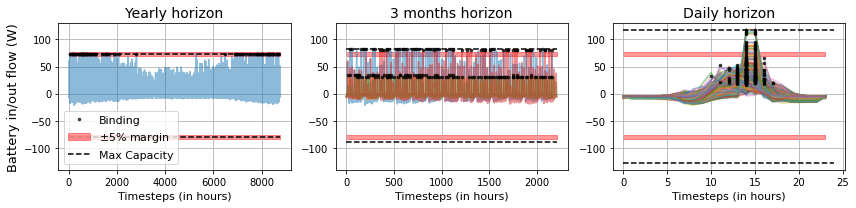

In [51]:
show_ramping(root, city='Duluth', building='SmallOffice', scenario=6, carbon=[2], horizon=['full','3M','d'])

done.                               


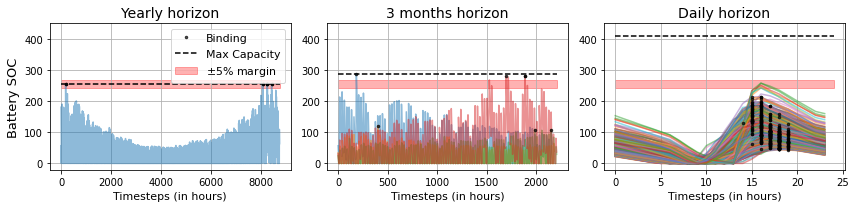

In [52]:
show_soc(root, city='Duluth', building='SmallOffice', scenario=6, carbon=[2], horizon=['full','3M','d'])

done.                               


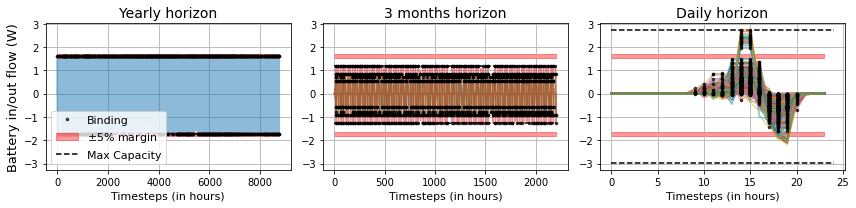

In [53]:
show_ramping(root, city='LosAngeles', building='Residential', scenario=8, carbon=[1], horizon=['full','3M','d'])

done.                               


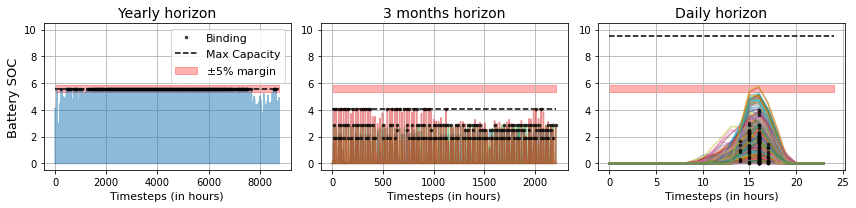

In [54]:
show_soc(root, city='LosAngeles', building='Residential', scenario=8, carbon=[1], horizon=['full','3M','d'])